<a href="https://colab.research.google.com/github/katha815/ADME-Classifier/blob/main/Different_ML_models_preliminary_Odata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prelminary testing - all ML model are not optimised
Feature groups: (1)6 phastCons scores, (2)6 phyloP scores, (3)vepDistance, (4){A-C,A-G,A-T,C-A,...}categorical input, (5)Ensemble search consequence , (6)corresponding SIFT and Polyphen scores.

## Module loading

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
!pip install scikit-optimize
import skopt
from skopt import BayesSearchCV

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 846.5 kB/s eta 0:00:00


## Data loading and testing/training split preparation

In [3]:
# Import data
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/Odata_fzero.csv")
# One hot encode with get_dummies
print(f"Whole data: {data2}\n")
Y = data2['Label']
X = data2[[col for col in data2.columns if col!="Location1" and col!="Location2" and
           col!="chr" and col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
print(X,'\n')
print(Y,'\n')

Whole data:     Chromo  Location1  Location2 Ref Alter  Label  chr  transcript_ablation  \
0     chr1   46930150   46930150   C     T      1    1                    0   
1     chr1   46930161   46930161   G     A      1    1                    0   
2     chr1   46932824   46932824   T     C      1    1                    0   
3     chr1   46932987   46932987   C     T      1    1                    0   
4     chr1   46934207   46934207   A     G      0    1                    0   
..     ...        ...        ...  ..   ...    ...  ...                  ...   
329  chr22   42129836   42129836   C     T      0   22                    0   
330  chr22   42130692   42130692   C     T      1   22                    0   
331  chr22   42130710   42130710   C     T      0   22                    0   
332  chr22   42130715   42130715   G     A      1   22                    0   
333  chr22   42130761   42130761   G     A      1   22                    0   

     splice_acceptor_variant  splice_do

In [4]:
## Prepare leave one chromosome out split indexes
chrom_values = X['Chromo'].unique()
grouped = X.groupby(['Chromo'])

# Initialization
datasplit = []
labels = []
combined_index = [None for _ in range(chrom_values.shape[0])]
test1ist = [None for _ in range(chrom_values.shape[0])]
train1ist = [None for _ in range(chrom_values.shape[0])]

# Extract info from grouped data
for n in range(chrom_values.shape[0]):
    chrom_i = chrom_values[n]
    new_data = grouped.get_group(chrom_i)  # Generate random data
    label = f"{chrom_i}"  # Generate label
    datasplit.append(new_data)  # Store data
    labels.append(label)  # Store label
print(type(datasplit[0].index),np.shape(datasplit[0].index))
print(datasplit[0].index.tolist())

# Convert it to chromo label and chromo-splitted testing sets
for i in range(len(labels)):
    print(f"Chromosome: {labels[i]}:")
    # print(f"Iteration: {i+1}\n")
    # print(f"Data_index: {datasplit[i].index}")
    print(f"Data_size: {len(datasplit[i])}")
    test1ist[i] = np.array(datasplit[i].index).tolist()
    # print(f"Test size: {len(test1ist[i])}\n")
    print(f"Test indexes: {test1ist[i]}\n")
    # Label: {labels[i]}\n {type(test1ist[i])}\n")

# Always merge the shortest lists, make sure the minimum length<20
while min(map(len, test1ist)) < 20 and len(test1ist) > 1:
    idx1, idx2 = sorted(range(len(test1ist)), key=lambda i: len(test1ist[i]))[:2] #not including 2, so 0/1
    print(test1ist[idx1], test1ist[idx2])
    test1ist[idx1] = test1ist[idx1] + test1ist[idx2]
    test1ist.pop(idx2)
# Check merged-testing sets length:
for x in test1ist:
    print(f"Test size: {len(x)};")

# Validation list: order = order+1 for the test1ist
vlist = test1ist[1:] + [test1ist[0]]
for x in vlist:
    print(f"Validation size: {len(x)};")

# Build training sets accordingly
all = list(range(len(X)))
# print(all)
train1ist = []
for i, test_indexes in enumerate(test1ist):
    train_indexes = np.array([index for index in all if index not in test_indexes])
    train1ist.append(train_indexes)
for x in train1ist:
    print(f"Train size: {len(x)};")
    # print(f"Train size: {len(train1ist[i])}\n")
    # print(f"Train indexes: {train1ist[i]}\n {type(train1ist[i])}\n")

<class 'pandas.core.indexes.numeric.Int64Index'> (18,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Chromosome: chr1:
Data_size: 18
Test indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

Chromosome: chr2:
Data_size: 28
Test indexes: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

Chromosome: chr3:
Data_size: 8
Test indexes: [46, 47, 48, 49, 50, 51, 52, 53]

Chromosome: chr4:
Data_size: 8
Test indexes: [54, 55, 56, 57, 58, 59, 60, 61]

Chromosome: chr6:
Data_size: 42
Test indexes: [62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]

Chromosome: chr7:
Data_size: 11
Test indexes: [104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]

Chromosome: chr8:
Data_size: 29
Test indexes: [115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,

In [5]:
# Finalizing
X = X.drop('Chromo', axis=1)
X = np.array([X.values.tolist()]).reshape(X.shape[0],-1)
Y = np.array([Y.values.tolist()]).reshape(X.shape[0],)
n_t = len(test1ist)

StandardScaler - Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

    z = (x - u) / s

In [6]:
# Preprocessing - Nomalization
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# Build simple training/testing sets
X_train0, X_test0, y_train0, y_test0 = train_test_split(X,Y,test_size=.25, random_state=42)
print("Size of train dataset: {}".format(X_train0.shape))
print("Size of test dataset: {}".format(X_test0.shape))
X_tr, X_v, y_tr, y_v = train_test_split(X_train0,y_train0,test_size=.25, random_state=42)
print("Size of training dataset: {}".format(X_tr.shape))
print("Size of validation dataset: {}".format(X_v.shape))

Size of train dataset: (250, 93)
Size of test dataset: (84, 93)
Size of training dataset: (187, 93)
Size of validation dataset: (63, 93)


## LOCO, simple split and Kfold for XGBoost model

###LOCO

In [8]:
n_t

9

### Simple split

In [9]:
## Simple Split

from sklearn.ensemble import GradientBoostingClassifier
classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
classifier.fit(X_train0, y_train0)
pred = classifier.predict(X_test0)

# Calculate and store
acc = accuracy_score(y_test0, pred)
auc = roc_auc_score(y_test0, pred)
acc_xg_tr = classifier.score(X_train0, y_train0)
acc_xg_v = acc
auc_xg_v = auc
print("Training Accuray: {:.2f}%".format(100*acc_xg_tr))
print("Model Accuray: {:.2f}%".format(100*acc))
print("Model AUC_ROC: {:.4f}".format(auc))

Training Accuray: 100.00%
Model Accuray: 63.10%
Model AUC_ROC: 0.6282


In [10]:
# Kfold
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  # fit model
  classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
  classifier.fit(X_train1, y_train1)
  # evaluate model
  yhat = classifier.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_xg_k = accuracy_score(y_true, y_pred1)
auc_xg_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_xg_k))
#61.42%->66.77%
print("Model AUC_ROC: {:.4f}".format(auc_xg_k))
#0.6009->0.6475

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Model Accuray: 65.27%
Model AUC_ROC: 0.6447


In [11]:
# LOCO
y_true, y_pred1 = list(), list()
n = 1
for i in range(len(test1ist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in train1ist[i]], [X[i] for i in test1ist[i]]
 y_train1, y_test1 = [Y[i] for i in train1ist[i]], [Y[i] for i in test1ist[i]]
 print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
 classifier.fit(X_train1, y_train1)
  # evaluate model
 yhat = classifier.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
# print('True y all: ', y_true, '\n')
# print('Estimated y all: ', y_pred1, '\n')
# print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_xg_lolo = accuracy_score(y_true, y_pred1)
auc_xg_lolo = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_xg_lolo))
print("Model AUC_ROC: {:.4f}".format(auc_xg_lolo))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Model Accuray: 61.38%
Model AUC_ROC: 0.6042


## Gradient Boosting Model

In [12]:
# Simple Split
from sklearn.ensemble import GradientBoostingClassifier
reg = GradientBoostingClassifier(random_state=0)
reg.fit(X_train0, y_train0)
pred = reg.predict(X_test0)
acc_gb_tr = reg.score(X_train0, y_train0)
acc_gb = accuracy_score(y_test0, pred)
auc_gb = roc_auc_score(y_test0, pred)
print("Training Accuray: {:.2f}%".format(100*acc_gb_tr))
print("Model Accuray: {:.2f}%".format(100*acc_gb))
print("Model AUC_ROC: {:.4f}".format(auc_gb))

Training Accuray: 100.00%
Model Accuray: 65.48%
Model AUC_ROC: 0.6526


In [13]:
# LOCO
y_true, y_pred1 = list(), list()
n = 1
for i in range(len(test1ist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in train1ist[i]], [X[i] for i in test1ist[i]]
 y_train1, y_test1 = [Y[i] for i in train1ist[i]], [Y[i] for i in test1ist[i]]
 print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 reg = GradientBoostingClassifier(random_state=0)
 reg.fit(X_train1, y_train1)
 # evaluate model
 yhat = reg.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
# print('True y all: ', y_true, '\n')
# print('Estimated y all: ', y_pred1, '\n')
# print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_gb_lolo = accuracy_score(y_true, y_pred1)
auc_gb_lolo = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_gb_lolo))
print("Model AUC_ROC: {:.4f}".format(auc_gb_lolo))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Model Accuray: 66.17%
Model AUC_ROC: 0.6513


####Kfold

In [14]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=n_t, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  reg = GradientBoostingClassifier(random_state=0)
  reg.fit(X_train1, y_train1)
  # evaluate model
  yhat = reg.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_gb_k = accuracy_score(y_true, y_pred1)
auc_gb_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_gb_k))
print("Model AUC_ROC: {:.4f}".format(auc_gb_k))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Model Accuray: 64.97%
Model AUC_ROC: 0.6391


Finding: the training and testing accuracy are the closest.

## Linear Model

Terminology: linear_model.SGDClassifier - This estimator implements regularized linear models with stochastic
gradient descent (SGD) learning: the gradient of the loss is estimated
each sample at a time and the model is updated along the way with a
decreasing strength schedule (aka learning rate).

In [15]:
# Linear Regression Model
# Terminology: Stochastic Gradient Descent (SGD) Classifier is an optimization algorithm used to find the values of parameters of a function
# that minimizes a cost function.
import math
from sklearn import datasets, linear_model
regr = linear_model.SGDClassifier()
regr.fit(X_train0, y_train0)
pred = regr.predict(X_test0)
acc_lr_tr = regr.score(X_train0, y_train0)
acc_lr_v = accuracy_score(y_test0, pred)
auc_lr_v = roc_auc_score(y_test0, pred)
print("Training Accuray: {:.2f}%".format(100*regr.score(X_train0, y_train0)))
print("Model Accuray: {:.2f}%".format(100*acc_lr_v))
print("Model AUC_ROC: {:.4f}".format(auc_lr_v))
#XGBoost
#Model Accuray: 67.06%
#Model AUC_ROC: 0.6509

Training Accuray: 74.80%
Model Accuray: 54.76%
Model AUC_ROC: 0.5474


Finding: Even linear model shows a low training accuracy??

In [16]:
# Linear Classifier LOCO
y_true, y_pred1 = list(), list()
n = 1
for i in range(len(test1ist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in train1ist[i]], [X[i] for i in test1ist[i]]
 y_train1, y_test1 = [Y[i] for i in train1ist[i]], [Y[i] for i in test1ist[i]]
 print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 regr = linear_model.SGDClassifier()
 regr.fit(X_train1, y_train1)
 # evaluate model
 yhat = regr.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_lr_lolo = accuracy_score(y_true, y_pred1)
auc_lr_lolo = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_lr_lolo))
#61.42%->66.77%
print("Model AUC_ROC: {:.4f}".format(auc_lr_lolo))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Model Accuray: 64.67%
Model AUC_ROC: 0.6437


In [17]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=n_t, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  # fit model
  regr = linear_model.SGDClassifier()
  regr.fit(X_train1, y_train1)
  # evaluate model
  yhat = regr.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_lr_k = accuracy_score(y_true, y_pred1)
auc_lr_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*auc_lr_k))
#61.42%->66.77%
print("Model AUC_ROC: {:.4f}".format(auc_lr_k))
#0.6009->0.6475

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Model Accuray: 58.69%
Model AUC_ROC: 0.5869


## --K-neighbor Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train0, y_train0)
pred = neigh.predict(X_test0)
acc_kn_tr = neigh.score(X_train0, y_train0)
acc_kn = accuracy_score(y_test0, pred)
auc_kn = roc_auc_score(y_test0, pred)
print("Training Accuray: {:.2f}%".format(acc_kn_tr))
print("Model Accuray: {:.2f}%".format(100*acc_kn))
#65-67%
print("Model AUC_ROC: {:.4f}".format(auc_kn))

Training Accuray: 0.78%
Model Accuray: 57.14%
Model AUC_ROC: 0.5689


*To make it more rigorous, tuning the hyperparameters with a separate set.

In [ ]:
# K-neighbour LOCO
y_true, y_pred1 = list(), list()
n = 1
for i in range(len(test1ist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in train1ist[i]], [X[i] for i in test1ist[i]]
 y_train1, y_test1 = [Y[i] for i in train1ist[i]], [Y[i] for i in test1ist[i]]
 print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 neigh = KNeighborsClassifier(n_neighbors=3)
 neigh.fit(X_train1, y_train1)
 # evaluate model
 yhat = neigh.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_kn_lolo = accuracy_score(y_true, y_pred1)
auc_kn_lolo = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_kn_lolo))
print("Model AUC_ROC: {:.4f}".format(auc_kn_lolo))
#Model Accuray: 75.37% for k_o = 7, but the tuning involves the testing data so it doesn't count
#Model AUC_ROC: 0.7354

#Collected acc: [0.5905044510385756, 0.5905044510385756, 0.6201780415430267, 0.5786350148367952, 0.6142433234421365, 0.6053412462908012, 0.6172106824925816, 0.6231454005934718, 0.6053412462908012, 0.5964391691394659]
# 0.6041543026706232
#Collected AUC: [0.5691013247404224, 0.5667919799498746, 0.5946473326172574, 0.5547261009667024, 0.5901539563193698, 0.5799498746867168, 0.5935553168635875, 0.5988184747583244, 0.5845685642678125, 0.57359470103831]
# 0.5805907626208378

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Model Accuray: 58.98%
Model AUC_ROC: 0.5828


Finding: First time I get both acc and auc over 70%!

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  # fit model
  neigh = KNeighborsClassifier(n_neighbors=3)
  neigh.fit(X_train1, y_train1)
  # evaluate model
  yhat = neigh.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_kn_k = accuracy_score(y_true, y_pred1)
auc_kn_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_kn_k))
print("Model AUC_ROC: {:.4f}".format(auc_kn_k))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Model Accuray: 64.67%
Model AUC_ROC: 0.6387


Finding: the k-Fold testing results are much lower, but we can also explain it with the hyposthesis that there are negative-effect training data when using k-Fold.

## SVM

In [18]:
# Support Vector Machine
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train0, y_train0)
pred = clf.predict(X_test0)
acc_svm_tr = clf.score(X_train0, y_train0)
acc_svm_v = accuracy_score(y_test0, pred)
auc_svm_v = roc_auc_score(y_test0, pred)
print("Training Accuray: {:.2f}%".format(100*clf.score(X_train0, y_train0)))
print("Model Accuray: {:.2f}%".format(100*acc_svm_v))
#65-67%
print("Model AUC_ROC: {:.4f}".format(auc_svm_v))

Training Accuray: 78.00%
Model Accuray: 67.86%
Model AUC_ROC: 0.6724


Caution: low training accuracy

In [19]:
# SVM LOCO
y_true, y_pred1 = list(), list()
n = 1
for i in range(len(test1ist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in train1ist[i]], [X[i] for i in test1ist[i]]
 y_train1, y_test1 = [Y[i] for i in train1ist[i]], [Y[i] for i in test1ist[i]]
 print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
 clf.fit(X_train1, y_train1)
 # evaluate model
 yhat = clf.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_svm_lolo = accuracy_score(y_true, y_pred1)
auc_svm_lolo = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_svm_lolo))
print("Model AUC_ROC: {:.4f}".format(auc_svm_lolo))
#Model Accuray: 63.20%
#Model AUC_ROC: 0.6098

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Model Accuray: 63.47%
Model AUC_ROC: 0.6221


In [20]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=n_t, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  # fit model
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  clf.fit(X_train1, y_train1)
  # evaluate model
  yhat = clf.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_svm_k = accuracy_score(y_true, y_pred1)
auc_svm_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*auc_svm_k))
print("Model AUC_ROC: {:.4f}".format(auc_svm_k))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Model Accuray: 67.37%
Model AUC_ROC: 0.6737


## Bayesian Model

In [21]:
# Bayesian Regression Model
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train0, y_train0)
pred = gnb.predict(X_test0)
acc_b_tr = gnb.score(X_train0, y_train0)
acc_b = accuracy_score(y_test0, pred)
auc_b = roc_auc_score(y_test0, pred)
print("Training Accuray: {:.2f}%".format(100*acc_b_tr))
print("Model Accuray: {:.2f}%".format(100*acc_b))
#65-67%
print("Model AUC_ROC: {:.4f}".format(auc_b))

Training Accuray: 70.00%
Model Accuray: 60.71%
Model AUC_ROC: 0.5998


In [23]:
# Bayesian LOCO
y_true, y_pred1 = list(), list()
n = 1
for i in range(len(test1ist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in train1ist[i]], [X[i] for i in test1ist[i]]
 y_train1, y_test1 = [Y[i] for i in train1ist[i]], [Y[i] for i in test1ist[i]]
 print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 gnb = GaussianNB()
 gnb.fit(X_train1, y_train1)
 # evaluate model
 yhat = gnb.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
# print('True y all: ', y_true, '\n')
# print('Estimated y all: ', y_pred1, '\n')
# print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_b_lolo = accuracy_score(y_true, y_pred1)
auc_b_lolo = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_b_lolo))
print("Model AUC_ROC: {:.4f}".format(auc_b_lolo))
#Model Accuray: 67.36%
#Model AUC_ROC: 0.6620

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Model Accuray: 61.68%
Model AUC_ROC: 0.5828


In [24]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=n_t, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  gnb = GaussianNB()
  gnb.fit(X_train1, y_train1)
  # evaluate model
  yhat = gnb.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_b_k = accuracy_score(y_true, y_pred1)
auc_b_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_b_k))
print("Model AUC_ROC: {:.4f}".format(auc_b_k))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Model Accuray: 60.48%
Model AUC_ROC: 0.5736


Finding: the training and testing accuracy are the closest.

## --NN Model

### Terminology Explanantion:

1. **Adam** is different to classical stochastic gradient descent.

Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

The authors describe Adam as combining the advantages of two other extensions of stochastic gradient descent. Specifically:

Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).
Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).
Adam realizes the benefits of both AdaGrad and RMSProp.

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

The initial value of the moving averages and beta1 and beta2 values close to 1.0 (recommended) result in a bias of moment estimates towards zero. This bias is overcome by first calculating the biased estimates before then calculating bias-corrected estimates.

2. The variability in accuracy between different training runs of the neural network model is due to the random initialization of the model's weights and biases. Neural networks often have many parameters, and these **randomly initialized** parameters can lead to different convergence paths during training. Therefore, it is common to observe some variability in the final accuracy across different runs.

### Model building

In [ ]:
#1 Initializatioin
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from skopt import BayesSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#2 Standardize the features
#2.1 Build training, validation and test sets/Extract individual index list
train_v_indexes = train1ist[-1]
val_indexes = vlist[-1]
test_indexes = test1ist[-1]
X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
X_test, y_test= X[test_indexes], Y[test_indexes]
print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    f"testing index: {len(test_indexes)}") #{test_indexes},

# scaler = StandardScaler()
# ***The purpose of scaling is to standardize the features so that they
# have zero mean and unit variance. This helps in preventing certain
# features from dominating the learning process and ensures better
# convergence during training.

#3 Buid NN Model
def build_nn_model(hidden_layers, units, learning_rate, epochs):
    # hidden_layers=1, units=16, learning_rate=0.001, epochs=10

    # #1 Preprocessing
    # scaler = StandardScaler()
    # X_train1 = scaler.fit_transform(X_train)
    # X_test1 = scaler.transform(X_test)

    #2 Input layer
    model = Sequential()
    model.add(Dense(units, input_dim=X.shape[1], activation='relu'))

    #3 Hidden layers: If hidden_layers is greater than 1, a loop
    # is used to add additional hidden layers, each having the
    # specified number of units and using the ReLU activation function.
    for _ in range(hidden_layers - 1):
        model.add(Dense(units, activation='relu'))

    #4 Output layer
    # Binary classifier with one output unit and sigmoid activation
    # model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])

    nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)

    return nn_model

# from keras.wrappers.scikit_learn import KerasClassifier
# model = KerasClassifier(build_fn=build_nn_model, epochs=10, verbose=0)
#(Keras.io) If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of dataset, generators, or keras.
# model = build_nn_model(1,16,0.001,10)
    #hidden_layers=1, units=16, learning_rate=0.001, epochs=10)
model = make_pipeline(StandardScaler(), build_nn_model(1,16,0.001,10))

training+validation index: 299;  testing index: 35


<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


###Simple Split

In [ ]:
acc_nn_tr = 0
model_result = make_pipeline(StandardScaler(), build_nn_model(1,16,0.001,10))
for _ in range(10):
  model = build_nn_model(1,16,0.001,10)
  model.fit(X_train0,y_train0)
  acc_nn_tr1 = model.score(X_train0, y_train0)
  print("Round Accuray: {:.2f}%".format(100*acc_nn_tr1))
  if acc_nn_tr1>acc_nn_tr:
    acc_nn_tr = acc_nn_tr1
    model_result = model
model_result.fit(X_train0, y_train0)
acc_nn = accuracy_score(y_test0, pred)
auc_nn = roc_auc_score(y_test0, pred)
print("Best Training Accuray: {:.2f}%".format(100*acc_nn_tr))
print("Model Accuray: {:.2f}%".format(100*acc_nn))
# 65-67%
print("Model AUC_ROC: {:.4f}".format(auc_nn))
print(pred)
print(y_test0)

<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


Round Accuray: 74.00%
Round Accuray: 71.20%
Round Accuray: 75.60%
Round Accuray: 72.00%
Round Accuray: 75.60%
Round Accuray: 71.60%
Round Accuray: 70.40%
Round Accuray: 70.80%
Round Accuray: 75.20%
Round Accuray: 73.60%
Best Training Accuray: 75.60%
Model Accuray: 60.71%
Model AUC_ROC: 0.5998
[1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 1]
[1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1
 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1
 1 0 1 0 1 0 1 1 0 1]


###LOCO

In [ ]:
# Replacing loop with LOCO testing function

def loco_test(model, X, Y, trainlist,testlist):
  acc_scores = []
  #best_params_list = [
  yhat_all = []
  ytrue_all = []
  for i in range(len(testlist)):
    print(f"Iteration {i+1}; ")

    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing index: {len(test_indexes)}") #{test_indexes}
    #3 Create model and repeat training for optimal score
    acc_nn_tr = 0
    for _ in range(10):
      model = make_pipeline(StandardScaler(), build_nn_model(1,16,0.001,10))
      model.fit(X_train,y_train)
      acc_nn_tr1 = model.score(X_train, y_train)
      if acc_nn_tr1>acc_nn_tr:
        acc_nn_tr = acc_nn_tr1
        model_result = model
    print("Best Training Accuray: {:.2f}%".format(100*acc_nn_tr))
    yhat = model_result.predict(X_test)
    #6 Calculate and store
    acc = accuracy_score(y_test, yhat)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))

  """Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
  #7 Results for all testing folds
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores))) #redundant
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w = accuracy_score(ytrue_all, yhat_all)
  auc =  roc_auc_score(ytrue_all, yhat_all)
  acc_ave = np.mean(acc_scores)

  return acc_ave, acc_w, auc, yhat_all, ytrue_all

# No optimisation test
# model = build_nn_model(1,16,0.001,10)
model = make_pipeline(StandardScaler(), build_nn_model(1,16,0.001,10))
acc_ave, acc_w, auc, yhat_all, ytrue_all = loco_test(model, X, Y, train1ist,test1ist)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}".format(auc))
print("Prediction: {}".format(yhat_all))
acc_nn_lolo = acc_w
acc_nn_lolo = auc

Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 76.14%
1/1 [==============================] - 0s 266ms/step
Iteration Accuray: 53.57%
Iteration 2; 
training+validation index: 292;  testing index: 42


<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 74.66%
2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 71.43%
Iteration 3; 
training+validation index: 305;  testing index: 29


<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 76.72%
1/1 [==============================] - 0s 54ms/step
Iteration Accuray: 79.31%
Iteration 4; 
training+validation index: 305;  testing index: 29


<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 74.75%
1/1 [==============================] - 0s 115ms/step
Iteration Accuray: 75.86%
Iteration 5; 
training+validation index: 247;  testing index: 87


<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 77.33%
3/3 [==============================] - 0s 4ms/step
Iteration Accuray: 60.92%
Iteration 6; 
training+validation index: 314;  testing index: 20


<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 77.07%
1/1 [==============================] - 0s 64ms/step
Iteration Accuray: 45.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 79.00%
2/2 [==============================] - 0s 7ms/step
Iteration Accuray: 52.94%
Iteration 8; 
training+validation index: 304;  testing index: 30


<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 76.64%
1/1 [==============================] - 0s 58ms/step
Iteration Accuray: 66.67%
Iteration 9; 
training+validation index: 299;  testing index: 35


<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 74.92%
2/2 [==============================] - 0s 6ms/step
Iteration Accuray: 74.29%
Average Accuray: 64.44%
Whole Accuray: 64.67%
AUC Score: 0.6350
Prediction: [0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1
 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 1
 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0
 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0
 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1
 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1]


In [ ]:
acc_nn_lolo = acc_w
auc_nn_lolo = auc
print(acc_nn_lolo, auc_nn_lolo)

0.6467065868263473 0.6350176434210048


### Kfold

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  #3 Create model and repeat training for optimal score
  acc_nn_tr = 0
  acc_nn_tr = 0
  for _ in range(10):
    model = make_pipeline(StandardScaler(), build_nn_model(1,16,0.001,10))
    model.fit(X_train,y_train)
    acc_nn_tr1 = model.score(X_train1, y_train1)
    if acc_nn_tr1>acc_nn_tr:
      acc_nn_tr = acc_nn_tr1
      model_result = model
  print("Best Training Accuray: {:.2f}%".format(100*acc_nn_tr))
  yhat = model_result.predict(X_test1)
  #6 Calculate and store
  acc = accuracy_score(y_test1, yhat)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_nn_k = accuracy_score(y_true, y_pred1)
auc_nn_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_b_k))
print("Model AUC_ROC: {:.4f}".format(auc_b_k))

Iteration 1



<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 75.67%
2/2 [==============================] - 0s 5ms/step
Iteration accruacy:  0.7352941176470589 

Iteration 2



<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 74.33%
2/2 [==============================] - 0s 9ms/step
Iteration accruacy:  0.7352941176470589 

Iteration 3



<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 78.67%
2/2 [==============================] - 0s 5ms/step
Iteration accruacy:  0.8823529411764706 

Iteration 4



<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 75.33%
2/2 [==============================] - 0s 6ms/step
Iteration accruacy:  0.7058823529411765 

Iteration 5



<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 74.09%
2/2 [==============================] - 0s 7ms/step
Iteration accruacy:  0.696969696969697 

Iteration 6



<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 74.09%
2/2 [==============================] - 0s 5ms/step
Iteration accruacy:  0.7878787878787878 

Iteration 7



<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 76.08%
2/2 [==============================] - 0s 6ms/step
Iteration accruacy:  0.696969696969697 

Iteration 8



<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 75.42%
2/2 [==============================] - 0s 6ms/step
Iteration accruacy:  0.7272727272727273 

Iteration 9



<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 74.42%
2/2 [==============================] - 0s 5ms/step
Iteration accruacy:  0.7575757575757576 

Iteration 10



<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)
<ipython-input-90-e07abeadd33c>:54: DeprecationWarning: KerasClassifier is d

Best Training Accuray: 75.42%
2/2 [==============================] - 0s 5ms/step
Iteration accruacy:  0.6666666666666666 

Model Accuray: 63.47%
Model AUC_ROC: 0.6003


Finding: the training and testing accuracy are the closest.

## Results Display

<class 'numpy.ndarray'>


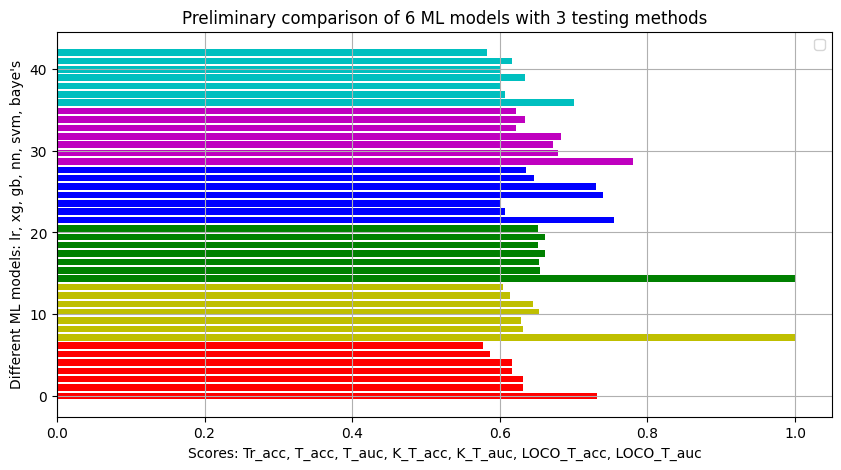

In [ ]:
## Display all results from different classifiers in one chart.
data = np.array([acc_lr_tr, acc_lr_v, auc_lr_v, acc_lr_k, auc_lr_k, acc_lr_lolo, auc_lr_lolo,
           acc_xg_tr, acc_xg_v, auc_xg_v, acc_xg_k, auc_xg_k, acc_xg_lolo, auc_xg_lolo,
            acc_gb_tr, acc_gb, auc_gb, acc_gb_k, auc_gb_k, acc_gb_lolo, auc_gb_lolo,
             acc_nn_tr, acc_nn, auc_nn, acc_nn_k, auc_nn_k, acc_nn_lolo, auc_nn_lolo,
              acc_svm_tr, acc_svm_v, auc_svm_v, acc_svm_k, auc_svm_lolo, acc_svm_lolo, auc_svm_lolo,
               acc_b_tr, acc_b, auc_b, acc_b_k, auc_b_k, acc_b_lolo, auc_b_lolo,]).reshape(-1, 1)
print(type(data))
plt.figure(figsize=(10,5))

# Define the labels for the data
#labels = ['1', '2', '3', '4', '5', '6', '7']
labels = np.linspace(0, 6*7, num=6*7)
# Plot the data as a bar chart and assign the labels to the bars
colors = ['r','r','r','r','r','r','r',
       'y','y','y','y','y','y','y',
        'g','g','g','g','g','g','g',
         'b','b','b','b','b','b','b',
          'm','m','m','m','m','m','m',
          'c','c','c','c','c','c','c']
for i in range(len(data)):
  plt.barh(labels[i], data[i], color=colors[i])#label=names[i],
# Add a legend to the plot
plt.legend()
# Set the x-axis ticks and labels

# Set the y-axis label
#plt.ylim(0.212,0.218)
plt.xlabel('Scores: Tr_acc, T_acc, T_auc, K_T_acc, K_T_auc, LOCO_T_acc, LOCO_T_auc')#,size=16
plt.ylabel('Different ML models: lr, xg, gb, nn, svm, baye\'s')#,size=16
plt.title("Preliminary comparison of 6 ML models with 3 testing methods")#(Scores:Tr_acc, T_acc, T_auc, K_T_acc, K_T_auc, LOCO_T_acc, LOCO T_auc;\n Different ML models: xg, lr, nn, svm, baye\'s)
#plt.xticks()
#plt.yticks()
plt.grid()

# Show the plot
plt.show()